## Energy-Conserving Galerkin Approximations for QG Dynamics
The Matrix Sizes are Tuned for Quick Running
With a High Performance Computer the matrix sizes can be expanded. 
This code has been run up to matrix sizes of 256.

A method is presented for constructing energy-conserving Galerkin approximations to the full quasigeostrophic model with active surface buoyancy. 
The derivation generalizes the approach of Rocha et al. (2016) [1] to allow for general bases.
Details are then presented for a specific set of bases: Legendre polynomials for potential vorticity and a recombined Legendre basis from Shen (1994) [2] for the streamfunction.
The method is tested in the context of linear baroclinic instability calculations, where it is compared to the standard second-order finite-difference method.
The Galerkin scheme is quite accurate even for a small number of basis functions N, and growth rates converge much more quickly for the Galerkin scheme than for the finite-difference scheme.
The Galerkin scheme can in some cases achieve the same accuracy as the finite difference scheme with ten times fewer degrees of freedom.

[1] C. B. Rocha, W. R. Young, I. Grooms, On galerkin approximations of the surface active quasigeostrophic equations,
J. Phys. Ocean. 46 (2016) 125-139.

[2] J. Shen, Effecient spectral-Galerkin method I. Direct solvers of second-and fourth-order equations using Legendre polyno-
mials, SIAM J. Sci. Comput. 15 (1994) 1489-1505.

# Dependencies
Only needs to be run once.

In [ ]:
Pkg.update()
Pkg.add("Jacobi")
Pkg.add("FastGaussQuadrature")
Pkg.add("PyPlot")

## Matrix Creation Methods

In [17]:
using FastGaussQuadrature
using Jacobi

nodePoints=200 # Number of quadrature nodes used to compute L matrix.

function b_n(n::Int64)
    numerator = -n*(n+1)
    denominator = (n+2)*(n+3)
    return numerator/denominator
end

function M_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1, j+1] = 2/(2*i+1) + (b_n(i)*b_n(i))*(2/(2*i+5))
            elseif i==j+2
                fullMatrix[i+1, j+1] = b_n(j)*(2/(2*j+5))
            elseif i==j-2
                fullMatrix[i+1, j+1] = b_n(i)*(2/(2*j+1))
            end
        end
    end
    return fullMatrix/2
end

function B_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1,j+1]=2/(2*i+1)
            elseif i==j-2
                fullMatrix[i+1,j+1]=b_n(i)*2/(2*i+5)
            end
        end
    end
    return fullMatrix/2
end

function L_ij(size::Int64, S::Function)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=i:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                dp_i = 2.*(djacobi(values[k+1],i,0,0)+b_n(i)*djacobi(values[k+1],i+2,0,0))
                dp_j = 2.*(djacobi(values[k+1],j,0,0)+b_n(j)*djacobi(values[k+1],j+2,0,0))
                newPiece = weights[k+1]*S((values[k+1]+1.)/2.)*dp_i*dp_j
                sumTotal = sumTotal + newPiece
            end
            fullArray[i+1,j+1] = .5*sumTotal
            fullArray[j+1,i+1] = .5*sumTotal
        end
    end
    return fullArray
end

function galerkin_p_psi_print(size::Int64, coefficients, value)
    sumTotal = 0
    for i=size-1:-1:0
        p = jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0)
        sumTotal = sumTotal + coefficients[i+1]*p
    end
    return sumTotal
end

galerkin_p_psi_print (generic function with 1 method)

# Galerkin Stability Methods
Generic Functions for Any Stability Problems

In [18]:
function dq_galerkin_coefficients(size::Int64, dq_bar::Function)
    fullArray = zeros(size)
    values, weights = gausslegendre(nodePoints)
    for i =0:size-1
        sumTotal = 0
        for k=0:nodePoints-1
            p_n = jacobi(values[k+1], i,0,0)
            sumTotal = sumTotal + weights[k+1]*p_n*dq_bar((values[k+1]+1.)/2.)
        end
        fullArray[i+1] = sumTotal*(2*i+1)/2
    end
    return fullArray
end

function dq_galerkin(size::Int64, coefficients, value::Float64)
    sumTotal = 0
    for i=0:size-1
        sumTotal = sumTotal + coefficients[i+1]*jacobi(2.*value-1.,i,0,0)
    end
    return sumTotal
end

function p_psi_function(size::Int64, value::Float64)
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)+b_n(i)*jacobi(2.*value-1.,i+2,0,0)
    end
    return fullArray
end

function p_q_function(size::Int64, value::Float64) # We shouldn't need this function
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)
    end
    return fullArray
end

function dy_vartheta_bar(S::Function, du_bar::Function, value::Float64)
    return -S(value)*du_bar(value)
end

function dy_psi(u_bar::Function, value::Float64)
    return -u_bar(value)
end

function dy_psi_galerkin(size::Int64, u_bar_coefficients, value::Float64)
    return -u_galerkin(size, u_bar_coefficients, value)
end

function u_galerkin_coefficients(size::Int64, dq_coefficients, dvt_plus, dvt_minus, first_u_coefficient, du_bar::Function, S::Function, LMatrix, BMatrix)
    r_piece1 = BMatrix*dq_coefficients
    r_piece2 = dvt_plus*p_psi_function(size,1.0)
    r_piece3 = dvt_minus*p_psi_function(size,0.0)
    rhs = r_piece1-r_piece2+r_piece3
    lhs = LMatrix[2:size,2:size]
    rhs = rhs[2:size]
    coefficients = lhs \ rhs
    return prepend!(coefficients,[first_u_coefficient])
end

function u_galerkin(size::Int64, coefficients, value)
    sumTotal = 0
    for i=0:size-1
        nextCoe = coefficients[i+1]
        sumTotal = sumTotal + coefficients[i+1]*(jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0))
    end
    return sumTotal
end

u_galerkin (generic function with 1 method)

# Stability Matricies Using Functions Above

In [19]:
function U_ij(size::Int64, u_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                p_psi = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_q = jacobi(values[k+1],j,0,0)
                u_galerk = u_galerkin(size, u_galerkin_coefficients, (values[k+1]+1.)/2.)
                sumTotal = sumTotal + weights[k+1]*p_psi*p_q*u_galerk
            end
            fullArray[i+1, j+1] = .5*sumTotal
        end
    end
    return fullArray
end

function Q_ij(size::Int64, dq_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=i:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                dq_galerk = dq_galerkin(size, dq_galerkin_coefficients, (values[k+1]+1.)/2.)
                p_psi_i = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_psi_j = jacobi(values[k+1],j,0,0)+b_n(j)*jacobi(values[k+1],j+2,0,0)
                sumTotal = sumTotal + weights[k+1]*dq_galerk*p_psi_i*p_psi_j
            end
            fullArray[i+1, j+1] = .5*sumTotal
            fullArray[j+1, i+1] = .5*sumTotal
        end
    end
    return fullArray
end

Q_ij (generic function with 1 method)

## Main Stability Calculation Methods

In [20]:
function psi(size, kx, ky, M_matrix, L_matrix, value)
    first_piece = (kx^2+ky^2)*M_matrix+L_matrix
    second_piece = p_psi_function(size, value)
    return first_piece \ second_piece
end

function computeMatricesForStabilityAnalysis(sizeOfMatrix, S_function, dq_function, du_function,dvt_plus, dvt_minus, first_coefficient)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, S_function)
    M = M_ij(sizeOfMatrix)
    dq_coefficients = dq_galerkin_coefficients(sizeOfMatrix, dq_function)
    u_coefficients = u_galerkin_coefficients(sizeOfMatrix, dq_coefficients, dvt_plus, dvt_minus, first_coefficient, du_function, S_function, L, B)

    U = U_ij(sizeOfMatrix, u_coefficients)
    Q = Q_ij(sizeOfMatrix, dq_coefficients)
    #println("Matrices Computed")
    return (B,L,M,U,Q, u_coefficients, dq_coefficients)
end

function getSimplifiedStabilityEigenObjectsOfKx(sizeOfMatrix, beta_value, ky, kxValues, S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    (B,L,M,U,Q,u_coefficients,dq_coefficients) = computeMatricesForStabilityAnalysis(sizeOfMatrix,S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    #Should have stable eigenvalues
    (values, vectors) = eig(U, B)
    if(minimum(imag(values))>0)
        println("Stable piece is unstable...")
    end
    
    eigenObjects = []
    for i=1:length(kxValues)
        kx = kxValues[i]
        ul = u_galerkin(sizeOfMatrix, u_coefficients, 1.)+dvt_plus*vecdot(p_psi_function(sizeOfMatrix, 1.),psi(sizeOfMatrix,kx,ky,M,L,1.))
        ur = -dvt_plus*vecdot(p_psi_function(sizeOfMatrix, 1.),psi(sizeOfMatrix,kx,ky,M,L,0.))
        ll = dvt_minus*vecdot(p_psi_function(sizeOfMatrix, 0.),psi(sizeOfMatrix,kx,ky,M,L,1.))
        lr = u_galerkin(sizeOfMatrix, u_coefficients, 0.)-dvt_minus*vecdot(p_psi_function(sizeOfMatrix, 0.),psi(sizeOfMatrix,kx,ky,M,L,0.))
        lhs = [[ul ur]; [ll lr]]
        eigenResult = eigfact(lhs)
        append!(eigenObjects, [eigenResult])
    end
    #println("Done computing eigenvalues and eigenvectors for all kx's")
    return eigenObjects
end

function getCompleteStabilityEigenObjectsOfKx(sizeOfMatrix, beta_value, ky, kxValues, S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    (B,L,M,U,Q,u_coefficients,dq_coefficients) = computeMatricesForStabilityAnalysis(sizeOfMatrix,S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    eigenObjects = []

    for i=1:length(kxValues)
        kx = kxValues[i]
        psi_plus = psi(sizeOfMatrix,kx,ky,M,L,1.)
        psi_minus = psi(sizeOfMatrix,kx,ky,M,L,0.)
        p_psi_plus = p_psi_function(sizeOfMatrix, 1.)
        p_psi_minus = p_psi_function(sizeOfMatrix, 0.)
        centerRowMatrix = ((kx^2+ky^2)*M+L)\B
        
        ul = u_galerkin(sizeOfMatrix, u_coefficients, 1.)+dvt_plus*vecdot(p_psi_plus,psi_plus)
        uc = -(dvt_plus)*(p_psi_plus'*centerRowMatrix)
        ur = -dvt_plus*vecdot(p_psi_plus, psi_minus)
        cl = (Q+beta_value*M)*psi_plus
        cc = U-(Q+beta_value*M)*centerRowMatrix
        cr = -(Q+beta_value*M)*psi_minus
        ll = dvt_minus*vecdot(p_psi_minus,psi_plus)
        lc = -(dvt_minus)*(p_psi_minus'*centerRowMatrix)
        lr = u_galerkin(sizeOfMatrix, u_coefficients, 0.)-dvt_minus*vecdot(p_psi_minus,psi_minus)
        lhs = [[ul uc ur];[cl cc cr];[ll lc lr]]
        lhs_small = [[ul ur]; [ll lr]]
        
        rhs = [[1 zeros(1,sizeOfMatrix) 0];[zeros(sizeOfMatrix,1) B zeros(sizeOfMatrix,1)]; [0 zeros(1,sizeOfMatrix) 1]]
        eigenResult = eigfact(lhs, rhs)
        append!(eigenObjects, [eigenResult])
    end
    #println("Done computing eigenvalues and eigenvectors for all kx's")
    return eigenObjects
end
    
function getStabilityValues(eigenObjectsArray, kxValues)
    steps = length(kxValues)
    growthRates = zeros(steps)
    waveSpeeds = zeros(steps)
    minWaveSpeeds = zeros(steps)
    eigenvectors = []
    
    for i=1:steps
        kx = kxValues[i]
        max_im, max_ind = findmax(imag(eigenObjectsArray[i][:values]))
        append!(eigenvectors, [eigenObjectsArray[i][:vectors][:,max_ind]])
        waveSpeeds[i] = real(eigenObjectsArray[i][:values][max_ind])
        minWaveSpeeds[i] = minimum(real(eigenObjectsArray[i][:values]))
        growthRates[i] = max_im*kx
    end
    
    return growthRates, eigenvectors, waveSpeeds
end

function createFourStabilityPlots(sizeOfMatrix, S_function, growthRates, eigenvectors, waveSpeeds, kx_values, ky_value)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, S_function)
    M = M_ij(sizeOfMatrix)
    
    maxIndex = indmax(growthRates)
    maxKx = kx_values[maxIndex]
    #println("Max growth rate at kx=$maxKx")

    highVector = eigenvectors[maxIndex]
    vectorSize = length(highVector)
    highVector_bottom = highVector[vectorSize] 
    psi_coeffs = highVector[1]*psi(sizeOfMatrix, maxKx, ky_value, M, L, 1.)-highVector_bottom*psi(sizeOfMatrix,maxKx,ky_value, M,L,0.)
    psi_coeffs = psi_coeffs - ( (maxKx^2 + ky_value^2)*M + L ) \ B*highVector[2:end-1]
    
    heights = linspace(0,1,100)
    psi_angles = zeros(length(heights))
    psi_amps = zeros(length(heights))
    for i=1:length(heights)
        psi_val = galerkin_p_psi_print(sizeOfMatrix, psi_coeffs, heights[i])
        psi_angles[i] = angle(psi_val)
        psi_amps[i] = abs(psi_val)
    end

    #print(kxs[25])
    fig, axes = subplots(2,2)
    ax = axes[1,1]
    ax[:plot](kx_values, growthRates, label="N = $matrixSize")
    ax[:legend](loc="upper right")
    ax = axes[2,1]
    ax[:plot](kx_values, waveSpeeds, "b-")
    
    ax = axes[1,2]
    ax[:plot](psi_angles - psi_angles[1], heights)

    ax = axes[2,2]
    ax[:plot](psi_amps/maximum(psi_amps), heights)
end

createFourStabilityPlots (generic function with 1 method)

# Eady Problem

# Eady Specific Functions

In [21]:
function z_linear(value::Float64)
    return value
end

function dz(value::Float64)
    return 1
end 

function dq(value::Float64)
    return 0
end

function S_constant(value::Float64)
    return 1.
end

S_constant (generic function with 1 method)

## Functions for Exact Eady Solution

In [22]:
using PyPlot

#Analytic Solution
function c(kxValue::Float64)
    inner = (kxValue/2-coth(kxValue/2))*(kxValue/2-tanh(kxValue/2))
    c_value = 1/2 + 1/kxValue*((Complex(inner))^(1/2))
    return c_value
end

function AB(kxValue::Float64)
    c_value = c(kxValue)
    matrix = [ 1 kxValue*c_value; (c_value-1)*kxValue*sinh(kxValue)+1*cosh(kxValue) (c_value-1)*kxValue*cosh(kxValue)+1*sinh(kxValue)]
    solutions = nullspace(matrix)
    return solutions
end

function waveFunction(kxValue::Float64, zHeight)
    ABVal = AB(kxValue)
    waveReturn = ABVal[1]*cosh(kxValue*zHeight)+ABVal[2]*sinh(kxValue*zHeight)
    return waveReturn
end

function createFourStabilityPlotsCompareToExact(sizeOfMatrix, S_function, growthRates, eigenvectors, waveSpeeds, kx_values, ky_value)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, S_function)
    M = M_ij(sizeOfMatrix)
    
    maxIndex = indmax(growthRates)
    maxKx = kx_values[maxIndex]
    highVector = eigenvectors[maxIndex]
    vectorSize = length(highVector)
    highVector_bottom = highVector[vectorSize] 
    psi_coeffs = highVector[1]*psi(sizeOfMatrix, maxKx, ky_value, M, L, 1.)-highVector_bottom*psi(sizeOfMatrix,maxKx,ky_value, M,L,0.)
    psi_coeffs = psi_coeffs - ( (maxKx^2 + ky_value^2)*M + L ) \ B*highVector[2:end-1]
    
    heights = linspace(0,1,100)
    psi_angles = zeros(length(heights))
    psi_amps = zeros(length(heights))
    psi_angles_exact = zeros(length(heights))
    psi_amps_exact = zeros(length(heights))
    for i=1:length(heights)
        psi_val = galerkin_p_psi_print(sizeOfMatrix, psi_coeffs, heights[i])
        psi_angles[i] = angle(psi_val)
        psi_amps[i] = abs(psi_val)
        
        psiValueExact = waveFunction(1.61, heights[i])
        psi_angles_exact[i]= angle(psiValueExact)
        psi_amps_exact[i] = abs(psiValueExact)
    end

    #Exact Growth Rates and wave speeds
    growthRates_exact = zeros(length(kx_values))
    w_speeds_exact = zeros(length(kx_values))
    for i =1:length(kx_values)
        c_value = c(kx_values[i])
        growthRates_exact[i] = kx_values[i]*imag(c_value)
        w_speeds_exact[i] = real(c_value)
    end
    
    plot(psi_amps/maximum(psi_amps), heights, label="Galerkin")
    plot(psi_amps_exact/maximum(psi_amps_exact), heights, label="Exact")
    legend(loc="center right")
    xlabel("Amplitude")
    ylabel("Height")
    savefig("EadyAmplitude.eps", format="eps", dpi=1000)
    cla()
    
    plot(kx_values, growthRates, label="Galerkin")
    plot(kx_values, growthRates_exact, label="Exact")
    legend(loc="upper right")
    xlabel("Zonal Wavenumber")
    ylabel("Growth Rate")
    savefig("EadyGrowthRates.eps", format="eps", dpi=1000)
    cla()
    
    plot(kx_values, waveSpeeds, label="Galerkin")
    plot(kx_values, w_speeds_exact, label="Exact")
    ylim(0,1)
    legend(loc="lower right")
    xlabel("Zonal Wavenumber")
    ylabel("Wave Speeds")
    savefig("EadyWaveSpeeds.eps", format="eps", dpi=1000) 
    cla()
    
    plot(psi_angles - psi_angles[1], heights, label="Galerkin")
    plot(psi_angles_exact - psi_angles_exact[1], heights, label="Exact")
    legend(loc="upper left")
    xlabel("Phase")
    ylabel("Height")
    savefig("EadyPhase.eps", format="eps", dpi=1000)
    
end

createFourStabilityPlotsCompareToExact (generic function with 1 method)

## Using the Eady Functions Above

In [ ]:
using PyPlot
ioff()

nodePoints = 200 # redefining for ease of alteration
matrixSize = 10

# Specific to the Eady Problem
first_coefficient = 0.5
beta = 0

kxStart = 0.1
kxFinish = 10.
steps = 100

ky = 0
kxs_eady_four = linspace(kxStart, kxFinish, steps) 
eigenValuesAndVectors_eady_four = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs_eady_four, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates_eady_four, vectors_eady_four, w_speeds_eady_four = getStabilityValues(eigenValuesAndVectors_eady_four, kxs_eady_four)

#createFourStabilityPlots(matrixSize, S_constant, growthRates_eady_four, vectors_eady_four, w_speeds_eady_four, kxs_eady_four, ky)

#The line below will generate comparison images of Galerkin to Exact
createFourStabilityPlotsCompareToExact(matrixSize, S_constant, growthRates_eady_four, vectors_eady_four, w_speeds_eady_four, kxs_eady_four, ky)

## Running on Max Single kx Value

In [ ]:
max_kxs = 1.61
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, max_kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates_max_eady, vectors_max_eady, w_speeds_max_eady = getStabilityValues(eigenValuesAndVectors, max_kxs)

# Green Problem

In [ ]:
using PyPlot
ioff()

function S_constant(value::Float64)
    return 1.
end

function dq(value::Float64)
    return 0
end

function z_linear(value::Float64)
    return value
end

function dz(value::Float64)
    return 1
end 

first_coefficient = 0.5
beta = 1

kxStart = 0.1
kxFinish = 10.
steps = 100
ky = 0

matrixSize = 16
kxs_green = linspace(kxStart, kxFinish, steps)
eigenValuesAndVectors_green_16 = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs_green, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates_green_16, vectors_green_16, w_speeds_green_16= getStabilityValues(eigenValuesAndVectors_green_16, kxs_green)

matrixSize = 64
eigenValuesAndVectors_64_green = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs_green, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates_green_64, eigenValuesAndVectors_64_green, w_speeds_64_green = getStabilityValues(eigenValuesAndVectors_64_green, kxs_green)
println("Done")
;

## Plotting the data from the Block Above

In [ ]:
plot(kxs_green, growthRates_green_16, label="N=16")
plot(kxs_green, growthRates_green_64, label="N=64")

title("Galerkin Method - Green Problem")
legend(loc="upper right")
savefig("G_Green.eps", format="eps", dpi=1000)

# Ocean-Charney Stability Methods

In [38]:
function u_OC(value)
    if(value isa Number)
        return 1/54*(3*exp(6*value -6)*(6*value -1) -2 -exp(-6))
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = 1/54*(3*exp(6*value[i] -6)*(6*value[i] -1) -2 +exp(-6))
        end
        return vector
    end
end

function dq_OC(value)  
    if(value isa Number)
        return -2
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = -2
        end
        return vector
    end
end

function S_OC(value)
    if(value isa Number)
        return exp(6-6*value)
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = exp(6-6*value[i])
        end
        return vector
    end
end
   
function du_OC(value)
    if(value isa Number)
        return 2*value*exp(6*(value-1))
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = 2*value[i]*exp(6*(value[i]-1))
        end
        return vector
    end
end

du_OC (generic function with 1 method)

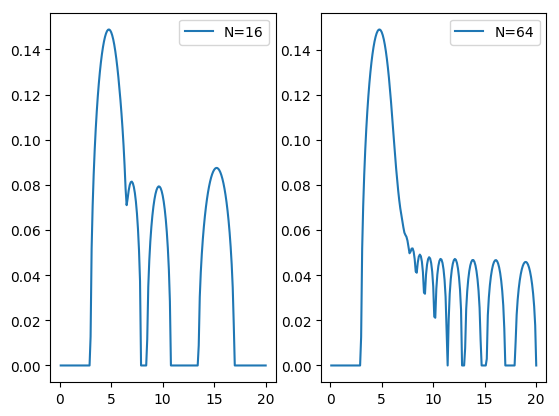

Done with 16


PyObject <matplotlib.legend.Legend object at 0x0000000001072160>

In [39]:
using PyPlot

first_coefficient = 0
beta = 1

kxStart = 0.1
kxFinish = 20.
steps = 200
ky = 0
kxs_OC = linspace(kxStart, kxFinish, steps)

matrixSize = 16
eigenValuesAndVectors_OC_16 = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs_OC, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
growthRates_OC_16, vectors_OC_16, w_speeds_OC_16 = getStabilityValues(eigenValuesAndVectors_OC_16, kxs_OC)
println("Done with 16")

matrixSize = 64
eigenValuesAndVectors_OC_64 = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs_OC, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
growthRates_OC_64, vectors_OC_64, w_speeds_OC_64 = getStabilityValues(eigenValuesAndVectors_OC_64, kxs_OC)

fig, axes = subplots(1,2)
ax = axes[1]
ax[:plot](kxs_OC, growthRates_OC_16, label="N=16")
ax[:legend](loc="upper right")
ax = axes[2]
ax[:plot](kxs_OC, growthRates_OC_64, label="N=64")
ax[:legend](loc="upper right")

#createFourStabilityPlots(matrixSize, S_OC, growthRates, vectors, w_speeds, w_minSpeeds, kxs, ky)

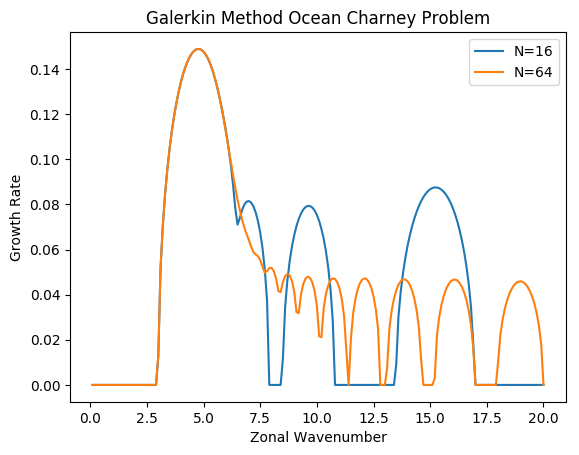

In [40]:
plot(kxs_OC, growthRates_OC_16, label="N=16")
plot(kxs_OC, growthRates_OC_64, label="N=64")
legend(loc="upper right")
title("Galerkin Method Ocean Charney Problem")
xlabel("Zonal Wavenumber")
ylabel("Growth Rate")
savefig("G_OceanCharney.eps", format="eps", dpi=1000)

## Stability Test of Maximum Wavenumber

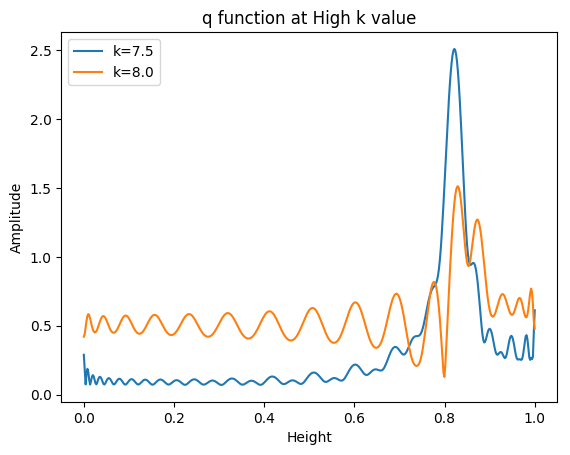

In [41]:
first_coefficient = 0
matrixSize = 32
#matrixSize = 128

beta = 1
ky = 0
kValue_OC_High = 8.

eigenValuesAndVectors_OC_128_Galerkin_8 = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kValue_OC_High, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
growthRates_OC_128_Galerkin_8, vectors_OC_128_Galerkin_8, w_speeds_OC_128_Galerkin_8 = getStabilityValues(eigenValuesAndVectors_OC_128_Galerkin_8, kValue_OC_High)


kValue_OC_High = 7.5

eigenValuesAndVectors_OC_128_Galerkin_7 = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kValue_OC_High, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
growthRates_OC_128_Galerkin_7, vectors_OC_128_Galerkin_7, w_speeds_OC_128_Galerkin_7 = getStabilityValues(eigenValuesAndVectors_OC_128_Galerkin_7, kValue_OC_High)

heights = linspace(0,1,500)
maxIndex = indmax(growthRates_OC_128_Galerkin_7)
highVector = vectors_OC_128_Galerkin_7[maxIndex]
q_coeffs_128_7 = highVector[2:end-1]
q_coeffs_128_8 = vectors_OC_128_Galerkin_8[1]
u_values_128_OC_7 = zeros(length(heights))
u_values_128_OC_8 = zeros(length(heights))
for i=1:length(heights)
    u_value_full_7 = u_galerkin(matrixSize, q_coeffs_128_7, heights[i])
    u_value_full_8 = u_galerkin(matrixSize, q_coeffs_128_8, heights[i])
    u_values_128_OC_7[i] = abs(u_value_full_7)
    u_values_128_OC_8[i] = abs(u_value_full_8)
end
plot(heights, u_values_128_OC_7, label="k=7.5")
plot(heights, u_values_128_OC_8, label="k=8.0")
legend(loc="upper left")
title("q function at High k value")
xlabel("Height")
ylabel("Amplitude")
savefig("OceanCharney_qfunction.eps", format="eps", dpi=1000)

## Comparison of U Galerkin Function at Different Matrix Sizes

In [ ]:
matrixSize = 32
B_32 = B_ij(matrixSize)
L_32 = L_ij(matrixSize, S_OC)
dq_coefficients_OC_32 = dq_galerkin_coefficients(matrixSize, dq_OC)
u_coefficients_32 = u_galerkin_coefficients(matrixSize, dq_coefficients_OC_32, -2., 0, 0, du_OC, S_OC, L_32, B_32)

matrixSize = 16
B_16 = B_ij(matrixSize)
L_16 = L_ij(matrixSize, S_OC)
dq_coefficients_OC_16 = dq_galerkin_coefficients(matrixSize, dq_OC)
u_coefficients_16 = u_galerkin_coefficients(matrixSize, dq_coefficients_OC_16, -2., 0, 0, du_OC, S_OC, L_16, B_16)

matrixSize = 8
B_8 = B_ij(matrixSize)
L_8 = L_ij(matrixSize, S_OC)
dq_coefficients_OC_8 = dq_galerkin_coefficients(matrixSize, dq_OC)
u_coefficients_8 = u_galerkin_coefficients(matrixSize, dq_coefficients_OC_8, -2., 0, 0, du_OC, S_OC, L_8, B_8)

matrixSize = 4
B_4 = B_ij(matrixSize)
L_4 = L_ij(matrixSize, S_OC)
dq_coefficients_OC = dq_galerkin_coefficients(matrixSize, dq_OC)
u_coefficients_4 = u_galerkin_coefficients(matrixSize, dq_coefficients_OC, -2., 0, 0, du_OC, S_OC, L_4, B_4)

n_32_values = zeros(100)
n_16_values = zeros(100)
n_8_values = zeros(100)
n_4_values = zeros(100)
heights = linspace(0,1,100)
real_Values = u_OC(heights)

for i=1:length(heights)
    n_32_values[i] = u_galerkin(32, u_coefficients_32, heights[i])
    n_16_values[i] = u_galerkin(16, u_coefficients_16, heights[i])
    n_8_values[i] = u_galerkin(8, u_coefficients_8, heights[i])
    n_4_values[i] = u_galerkin(4, u_coefficients_4, heights[i])
end

plot(real_Values, heights, label="Real")
plot(n_32_values, heights, label="N=32")
plot(n_16_values, heights, label="N=16")
plot(n_8_values, heights, label="N=8")
plot(n_4_values, heights, label="N=4")
legend(loc="lower right")
ylabel("Height")
xlabel("u(z)")
title("Charney Problem U Function Galerkin Approximation")
savefig("UFunctions.eps", format="eps", dpi=1000)

# Phillips Stability

In [66]:
function u_Phillips(value)
    if(value isa Number)
        return -cos(pi*value)/pi
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = -cos(pi*value[i])/pi
        end
        return vector
    end
end

function dq_Phillips(value)  
    if(value isa Number)
        return pi*cos(pi*value)
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = pi*cos(pi*value[i])
        end
        return vector
    end
end

function S_Phillips(value)
    if(value isa Number)
        return 1
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = 1
        end
        return vector
    end
end
   
function du_Phillips(value)
    if(value isa Number)
        return sin(pi*value)
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = sin(pi*value[i])
        end
        return vector
    end
end

du_Phillips (generic function with 1 method)

In [ ]:
using PyPlot
first_coefficient = 0
matrixSize = 13

kxStart = 0.1
kxFinish = 4.
steps = 400
beta = 3.1
ky = 0
kxs_phil = linspace(kxStart, kxFinish, steps)
eigenValuesAndVectors_Phil = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs_phil, S_Phillips, dq_Phillips, du_Phillips, 0, 0, first_coefficient)
growthRates_13_Phil, vectors, w_speeds = getStabilityValues(eigenValuesAndVectors_Phil, kxs_phil)

plot(kxs_phil, growthRates_13_Phil, label="Growth Rates at N = 13")
#legend(loc="upper right")

## Error Comparison at Highest Wave Number

In [ ]:
matrixSize = 32
first_coefficient = 0
beta = 3.1
ky = 0
kxValue = 3.
eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxValue, S_Phillips, dq_Phillips, du_Phillips, 0, 0, first_coefficient)
growthRates_280_Phil_G, vectors, w_speeds= getStabilityValues(eigenValuesAndVectors, kxValue)


nValues = round.(Int64,logspace(0.8, 1.408,15))
#nValues = round.(Int64,logspace(0.8, 2.408,15))
growthRates_forN_Phil = zeros(length(nValues))
kxValue = 3.
for i =1:length(nValues)
    matrixSize = nValues[i]
    println("Working on $matrixSize")
    eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxValue, S_Phillips, dq_Phillips, du_Phillips, 0, 0, first_coefficient)
    growthRate, vectors, w_speeds = getStabilityValues(eigenValuesAndVectors, kxValue)
    growthRates_forN_Phil[i] = growthRate[1]
end

semilogy(nValues, abs.(growthRates_forN_Phil-growthRates_280_Phil_G[1]), label="Growth Rate Approach")
legend(loc="upper right")


In [ ]:
first_coefficient = 0
beta = 3.1
ky = 0
bestPoint, bestKxIndex_Phil = findmax(growthRates_Phil_fd)
nValues = round.(Int64,logspace(0.8, 2.408,15))
growthRates_forN_Phil_G = zeros(length(nValues))
kxValue = 3.
println(bestPoint)
for i =1:length(nValues)
    matrixSize = nValues[i]
    println("Working on $matrixSize")
    eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxValue, S_Phillips, dq_Phillips, du_Phillips, 0, 0, first_coefficient)
    growthRate, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxValue)
    growthRates_forN_Phil_G[i] = growthRate[1]
    println(growthRate)
end

plot(nValues, abs.(growthRates_forN_Phil_G-bestPoint))
yscale("log")
title("Finite Difference Growth Rate Approach Phillips Problem")
xlabel("Zonal Wavenumber")
ylabel("Difference from Actual")

In [ ]:
bestPoint = growthRates_280_Phil_G[1]
plot(nValues, abs.(growthRates_forN_Phil-bestPoint))
yscale("log")
title("Galerkin Growth Rate Approach Phillips Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
savefig("PhillipsProblemApproachFull.eps", format="eps", dpi=1000)

# Stability - Finite Difference Analysis

In [2]:
function z_elements(size)
    stepSize = 1/size
    elements = zeros(size)
    elements[1] = stepSize/2
    for i = 2:size
        elements[i] = elements[i-1]+stepSize;
    end
    return elements
end

function U_fd(size, u_function)
    z_k = z_elements(size)
    fullMatrix = Diagonal(u_function(z_k))
    return fullMatrix
end

function L_fd(size, S)
    deltaZ = 1/size
    fullMatrix = zeros(size, size)
    fullMatrix[1,1] = S(deltaZ)
    fullMatrix[1,2] = -S(deltaZ)
    fullMatrix[size,size] = S((size-1)*deltaZ)
    fullMatrix[size,size-1] = -S((size-1)*deltaZ)
    for i=2:size-1
        fullMatrix[i, i-1] = -S((i-1)*deltaZ)
        fullMatrix[i,i] = S((i-1)*deltaZ)+S(i*deltaZ)
        fullMatrix[i, i+1] = -S(i*deltaZ)
    end
    normalize = 1./(deltaZ^2)
    return fullMatrix*normalize
end

function Q_fd(size, u_function, L_matrix)
    zk = z_elements(size)
    u_matrix = u_function(zk)
    diagonals = L_matrix*u_matrix
    fullMatrix = Diagonal(diagonals)
    return fullMatrix
end

#z_elements(8)
#L = L_fd(5, z_linear)
#Q_fd(5,u_linear,L)

Q_fd (generic function with 1 method)

In [5]:
function u_linear(value)
    return value
end

function growthRateEigenValues_fd(sizeOfMatrix, beta_value, ky, kxValues, S_function, u_function)
    U = U_fd(sizeOfMatrix, u_function)
    L = L_fd(sizeOfMatrix, S_function)
    Q = Q_fd(sizeOfMatrix, u_function, L)
    #println("FD Matrices Computed")
    
    steps = length(kxValues)
    
    growthRates = zeros(steps)
    waveSpeeds = zeros(steps)
    eigenvectors = []
    for i=1:steps
        #println()
        kx = kxValues[i]
        lhs = U*(Diagonal(zeros(sizeOfMatrix)+(kx^2+ky^2))+L) - (Q+Diagonal(zeros(sizeOfMatrix)+beta_value))
        rhs = Diagonal(zeros(sizeOfMatrix)+(kx^2+ky^2))+L
        #println(lhs)
        eigenObject = eigfact(lhs, rhs)
        max_im, max_ind = findmax(imag(eigenObject[:values]))
        #println(eigenObject[:vectors])
        append!(eigenvectors, [eigenObject[:vectors][:,max_ind]])
        waveSpeeds[i] = real(eigenObject[:values][max_ind])
        growthRates[i] = max_im*kx
    end
    return growthRates, eigenvectors, waveSpeeds
end

growthRateEigenValues_fd (generic function with 1 method)

# Finite Difference - Eady Problem

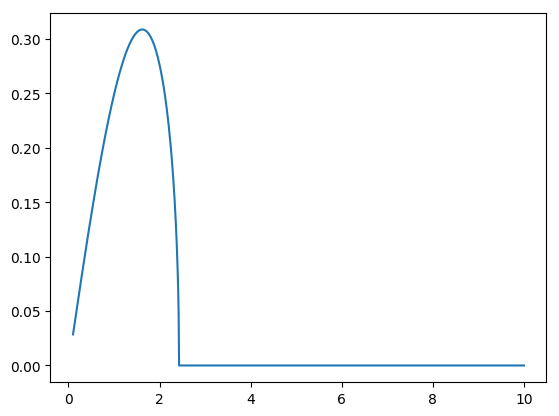

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000217BE48>

In [9]:
using PyPlot

function S_constant(value::Float64)
    return 1.
end

matrixSize = 7

kxStart = 0.1
kxFinish = 10.
steps = 1000
beta = 0
ky = 0

kxs_eady = linspace(kxStart, kxFinish, steps)
growthRates_Eady_fd, vectors_Eady_fd, w_speeds_Eady_fd = growthRateEigenValues_fd(matrixSize, beta, ky, kxs_eady, S_constant, u_linear)
plot(kxs_eady, growthRates_Eady_fd)

## FD - Green Problem

In [12]:
using PyPlot
matrixSize = 16

kxStart = 0.1
kxFinish = 10.
steps = 1000
beta = 1
ky = 0

kxs_green_fd = linspace(kxStart, kxFinish, steps)
growthRates_fd_green_16, vectors_fd_green_16, w_speeds_fd_green_16 = growthRateEigenValues_fd(matrixSize, beta, ky, kxs_green_fd, S_constant, u_linear)

matrixSize = 128
growthRates_fd_green_128, vectors_fd_green_128, w_speeds_fd_green_128 = growthRateEigenValues_fd(matrixSize, beta, ky, kxs_green_fd, S_constant, u_linear)
println("Done")
;

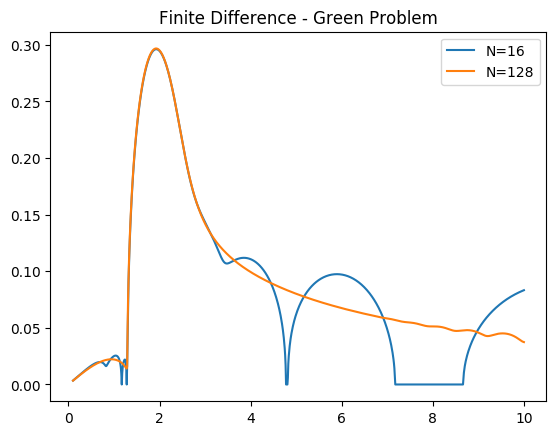

In [11]:
plot(kxs_green_fd, growthRates_fd_green_16, label="N=16")
plot(kxs_green_fd, growthRates_fd_green_128, label="N=128")
title("Finite Difference - Green Problem")
legend(loc="upper right")
savefig("FDGreen.eps", format="eps", dpi=1000)

# Comparison Finite Difference to Galerkin

In [29]:
using PyPlot
ion()

#Requires Exact Eady Method BLock to be Run from Above

nodePoints = 300 # redefining for ease of alteration

first_coefficient = 0.5
steps = 1
beta = 0
ky = 0
kxs = 1.61

nValues = round.(Int64,logspace(0.8, 1.408,15))

#Use below for larger range
#nValues = round.(Int64,logspace(0.8, 2.408,15))
println(nValues)
growthRates_galerkin_eady = zeros(length(nValues))
growthRates_fd_eady = zeros(length(nValues))

bestValue_eady = 1.61*imag(c(1.61))

for i = 1:length(nValues)
    nV = round(Int64, nValues[i])
    matrixSize = nV
    eigenValuesAndVectors_g = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
    growthRate_g, vectors_g, w_speeds_g = getStabilityValues(eigenValuesAndVectors_g, kxs)
    growthRates_galerkin_eady[i] = growthRate_g[1]
    
    matrixSize = nV + 2
    growthRate_fd, vectors_fd, w_speeds_fd = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_constant, u_linear)
    growthRates_fd_eady[i] = growthRate_fd[1]
end


[6, 7, 8, 9, 9, 10, 11, 13, 14, 16, 17, 19, 21, 23, 26]


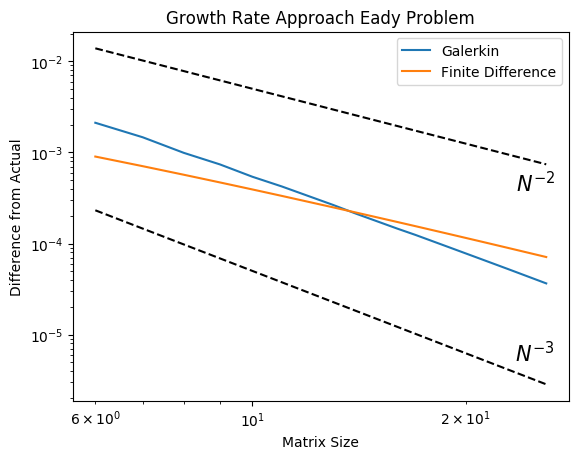

In [30]:
diffs = abs.(growthRates_galerkin_eady-bestValue_eady)
diffs_fd = abs.(growthRates_fd_eady-bestValue_eady)
wholes = round.(nValues)
plot(wholes,diffs, label="Galerkin")
plot(wholes,diffs_fd, label="Finite Difference")
plot(wholes, .5*float(wholes).^-2, color="k", linestyle="dashed")
plot(wholes, .05*float(wholes).^-3, color="k", linestyle="dashed")
title("Growth Rate Approach Eady Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
yscale("log")
xscale("log")
legend(loc="upper right")
annotate(L"$N^{-2}$",
	xy=[1;0.52],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
annotate(L"$N^{-3}$",
	xy=[1;0.06],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
savefig("EadyApproach.eps", format="eps", dpi=1000)

# Finite Difference - Ocean Charney

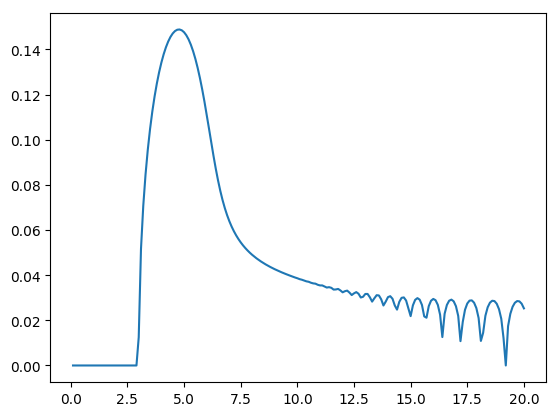

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000346E0F28>

In [34]:
using PyPlot

# Requires Ocean-Charney Stability Methods Block from Above

matrixSize = 280

kxStart = 0.1
kxFinish = 20.
steps = 200
beta = 1
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
growthRates_fd_280_OC, vectors, w_speeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_OC, u_OC)
plot(kxs, growthRates_fd_280_OC, label="N = $matrixSize")

## Comparison to Galerkin
Requires the Galerkin Method Block from Above

In [51]:
matrixSize = 32
#matrixSize = 128

kxStart = 0.1
kxFinish = 20.
steps = 200
beta = 1
ky = 0

kxs = 5
growthRates_fd_128_OC_2, vectors_128_FD_OC, w_speeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, S_OC, u_OC)
println("Done")

Done


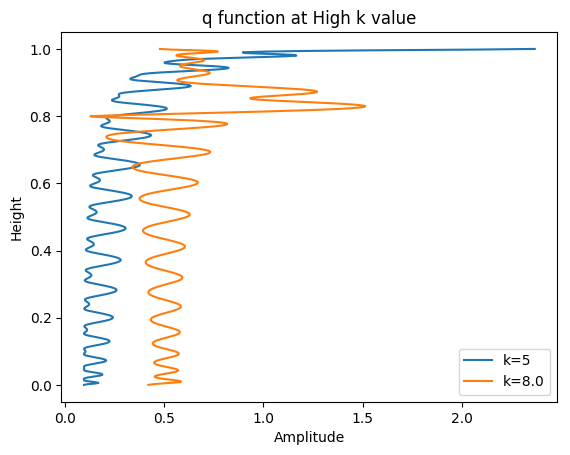

In [52]:
heights = linspace(0,1,500)
maxIndex = indmax(growthRates_fd_128_OC_2)
highVector = vectors_128_FD_OC[maxIndex]
q_coeffs_128_5 = highVector
q_coeffs_128_8 = vectors_OC_128_Galerkin_8[1]
u_values_128_OC_5 = zeros(length(heights))
u_values_128_OC_8 = zeros(length(heights))
for i=1:length(heights)
    u_value_full = u_galerkin(matrixSize, q_coeffs_128_5, heights[i])
    u_value_full_8 = u_galerkin(matrixSize, q_coeffs_128_8, heights[i])
    u_values_128_OC_5[i] = abs(u_value_full)
    u_values_128_OC_8[i] = abs(u_value_full_8)
end
plot(u_values_128_OC_5, heights, label="k=5")
plot(u_values_128_OC_8, heights, label="k=8.0")
legend(loc="lower right")
title("q function at High k value")
ylabel("Height")
xlabel("Amplitude")
savefig("OceanCharney_qfunction.eps", format="eps", dpi=1000)

## Finite Difference Comparison of Ocean Charney

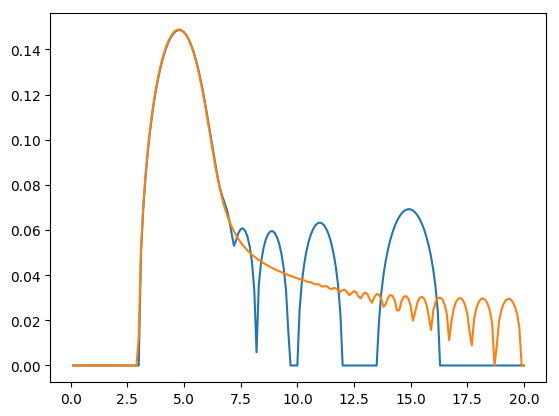

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000346A8E48>

In [35]:
matrixSize = 256

kxStart = 0.1
kxFinish = 20.
steps = 200
beta = 1
ky = 0

kxs_OC_fd = linspace(kxStart, kxFinish, steps)
growthRates_fd_256_OC, vectors_256_fd, w_speeds_256_fd = growthRateEigenValues_fd(matrixSize, beta, ky, kxs_OC_fd, S_OC, u_OC)
matrixSize = 32
growthRates_fd_32_OC, vectors_32_fd, w_speeds_32_fd= growthRateEigenValues_fd(matrixSize, beta, ky, kxs_OC_fd, S_OC, u_OC)

plot(kxs_OC_fd, growthRates_fd_32_OC, label="N = 32")
plot(kxs_OC_fd, growthRates_fd_256_OC, label="N = 256")

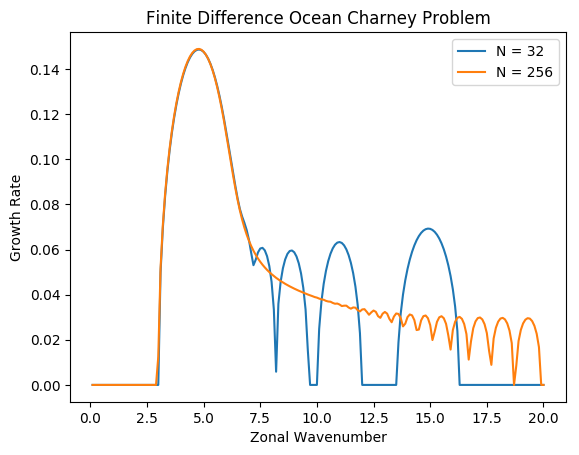

In [54]:
plot(kxs_OC_fd, growthRates_fd_32_OC, label="N = 32")
plot(kxs_OC_fd, growthRates_fd_256_OC, label="N = 256")
legend(loc="upper right")
title("Finite Difference Ocean Charney Problem")
xlabel("Zonal Wavenumber")
ylabel("Growth Rate")
savefig("FD_OceanCharney.eps", format="eps", dpi=1000)

4.8


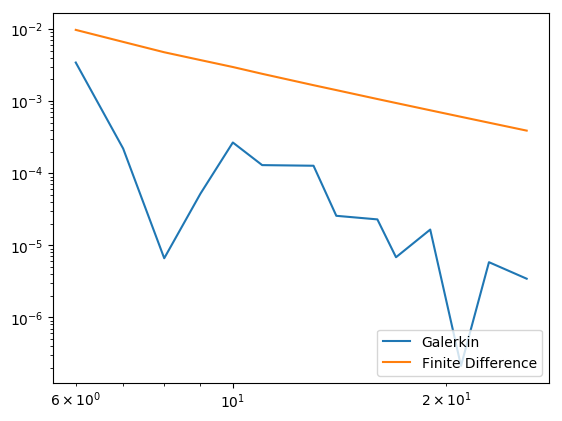

[0.145437, 0.14909, 0.148864, 0.148922, 0.148922, 0.148604, 0.148741, 0.148997, 0.148896, 0.148847, 0.148877, 0.148887, 0.14887, 0.148876, 0.148874]
[0.139124, 0.142231, 0.144102, 0.145156, 0.145156, 0.145895, 0.146475, 0.147206, 0.147447, 0.1478, 0.147928, 0.148124, 0.148264, 0.148368, 0.14848]
(0.1488703140734919, 48)


PyObject <matplotlib.legend.Legend object at 0x000000000439A978>

In [60]:
first_coefficient = 0

kxStart = 0.1
kxFinish = 20.
steps = 200
beta = 1
ky = 0

nValues = round.(Int64,logspace(0.8, 1.408,15))

#Use below for larger range
#nValues = round.(Int64,logspace(0.8, 2.408,15))

growthRates_galerkin_OC=zeros(length(nValues))
growthRates_fd_OC = zeros(length(nValues))

bestValue_OC = findmax(growthRates_fd_280_OC)
kxValue = kxs_OC_fd[bestValue_OC[2]]
println(kxValue)

for i = 1:length(nValues)
    nV = round(Int64, nValues[i])
    matrixSize = nV
    eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxValue, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
    growthRates_g, vectors_g, w_speeds_g = getStabilityValues(eigenValuesAndVectors, kxValue)
    growthRates_galerkin_OC[i] = growthRates_g[1]
    growthRates_fd, vectors_fd, w_speeds_fd= growthRateEigenValues_fd(matrixSize, beta, ky, kxValue, S_OC, u_OC)
    growthRates_fd_OC[i] = growthRates_fd[1]
end

println(growthRates_galerkin_OC)
println(growthRates_fd_OC)
println(bestValue_OC)
plot(nValues,abs.(growthRates_galerkin_OC-bestValue_OC[1]), label="Galerkin")
plot(nValues, abs.(growthRates_fd_OC-bestValue_OC[1]), label="Finite Difference")
yscale("log")
xscale("log")
legend(loc="lower right")

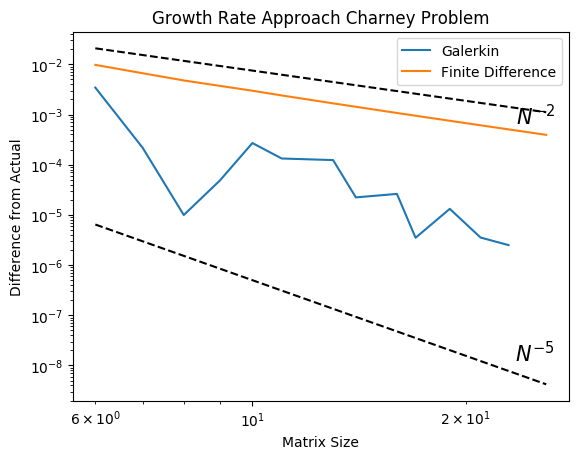

[0.145437, 0.14909, 0.148864, 0.148922, 0.148922, 0.148604, 0.148741, 0.148997, 0.148896, 0.148847, 0.148877, 0.148887, 0.14887, 0.148876, 0.148874]
[0.139124, 0.142231, 0.144102, 0.145156, 0.145156, 0.145895, 0.146475, 0.147206, 0.147447, 0.1478, 0.147928, 0.148124, 0.148264, 0.148368, 0.14848]
(0.14887363941513063, 48)


In [64]:
bestValue_OC= findmax(growthRates_OC_64)
println(growthRates_galerkin_OC)
println(growthRates_fd_OC)
println(bestValue_OC)
plot(nValues[1:end-1],abs.(growthRates_galerkin_OC[1:end-1]-bestValue_OC[1]), label="Galerkin")
plot(nValues, abs.(growthRates_fd_OC-bestValue_OC[1]), label="Finite Difference")
plot(wholes, .75*float(wholes).^-2, color="k", linestyle="dashed")
plot(wholes, .05*float(wholes).^-5, color="k", linestyle="dashed")
title("Growth Rate Approach Charney Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
yscale("log")
xscale("log")
legend(loc="upper right")
annotate(L"$N^{-2}$",
	xy=[1;0.7],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
annotate(L"$N^{-5}$",
	xy=[1;0.06],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
savefig("OCApproach.eps", format="eps", dpi=1000)

# Finite Difference - Phillips

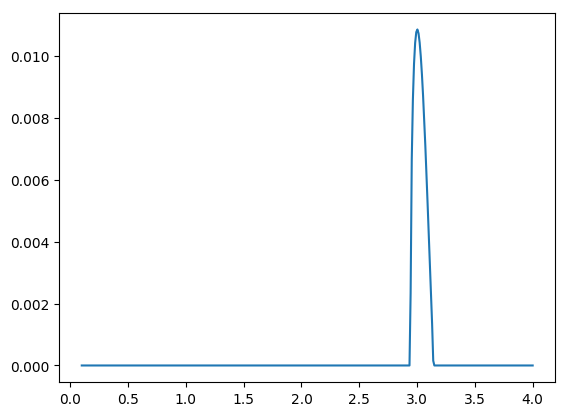

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000484FF28>

In [69]:
using PyPlot

# Requires Phillips Block from Above

#matrixSize = 280
matrixSize = 120

kxStart = .1
kxFinish = 4.
steps = 400
beta = 3.1
ky = 0

kxs_phil_fd = linspace(kxStart, kxFinish, steps)
growthRates_Phil_fd, vectors_phil_fd, w_speeds_phil_fd = growthRateEigenValues_fd(matrixSize, beta, ky, kxs_phil_fd, S_Phillips, u_Phillips)
plot(kxs,growthRates_Phil_fd)

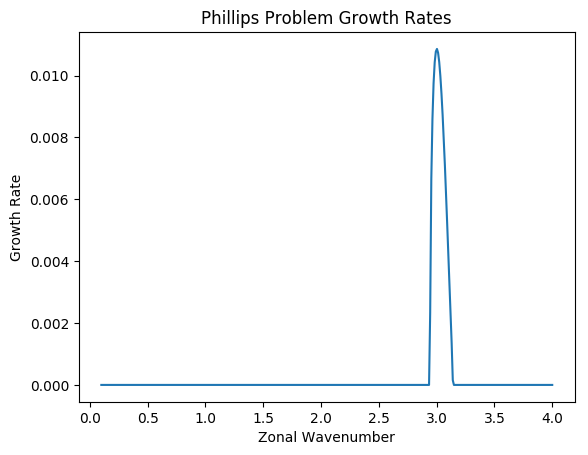

In [70]:
kxStart = .1
kxFinish = 4.
steps = 400
beta = 3.1
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
plot(kxs,growthRates_Phil_fd)
title("Phillips Problem Growth Rates")
xlabel("Zonal Wavenumber")
ylabel("Growth Rate")
savefig("PhillipsProblem.eps", format="eps", dpi=1000)

In [75]:

nValues = round.(Int64,logspace(0.8, 1.408,15))

#Use below for larger range
#nValues = round.(Int64,logspace(0.8, 2.408,15))

bestValue_fd, bestKxIndex_Phil = findmax(growthRates_Phil_fd)
growthRates_forN_Phil_fd = zeros(length(nValues))
kxValue_Phil = 3.
for i =1:length(nValues)
    matrixSize = nValues[i]
    growthRates_fd, vectors, w_speeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxValue_Phil, S_Phillips, u_Phillips)
    growthRates_forN_Phil_fd[i] = growthRates_fd[1]
end
println("Done")

Done


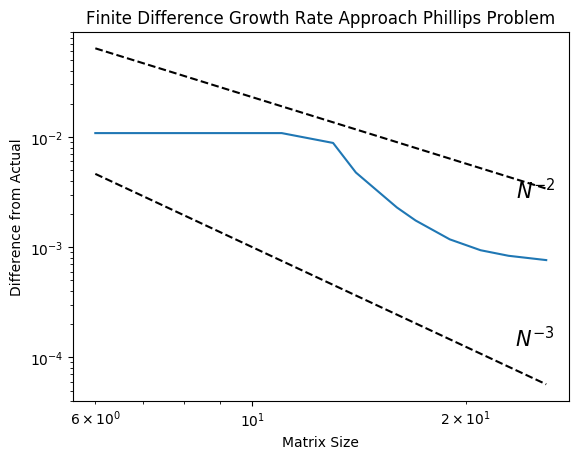

In [77]:
plot(nValues, abs.(growthRates_forN_Phil_fd-bestValue_fd[1]))
plot(nValues, 2.3*float(nValues).^-2, color="k", linestyle="dashed")
plot(nValues, float(nValues).^-3, color="k", linestyle="dashed")
xscale("log")
yscale("log")
title("Finite Difference Growth Rate Approach Phillips Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
annotate(L"$N^{-2}$",
	xy=[1;0.5],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
annotate(L"$N^{-3}$",
	xy=[1;0.1],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
savefig("PhillipsProblemFDApproach.eps", format="eps", dpi=1000)

# First Baroclinic Mode Comparison

In [ ]:
using PyPlot

function isNonZero(value)
    return (value != 0)
end

function firstBaroclinic(value)
    return cos.(pi*value)
end

function computeFirstBaroclinicError(matrixSize, trueFirstFuction, stepsZeroToOne, S_function)
    #Compute Matricies
    M = M_ij(matrixSize)
    #spy(Hermitian(M))
    L = L_ij(matrixSize, S_function)
    G = chol(M)'

    #Compute eigenvalues and eigenvectors
    LGL = (G\L)/(G')
    eigenObject = eigfact(LGL)
    e_vectors = eigenObject[:vectors]
    e_values = eigenObject[:values]
    minimumNonZero = minimum(filter!(isNonZero,e_values))
    index = findfirst(e_values, minimumNonZero)
    neededEVector = e_vectors[:,index]
    neededEVector = (LGL - e_values[index]*eye(matrixSize))\neededEVector
    neededEVector = G'\neededEVector
    
    #Calculate Error
    z, weights = gausslegendre(stepsZeroToOne)
    real = trueFirstFuction(z)
    estimate = galerkin_p_psi_print(matrixSize, neededEVector, z)
    normalizationFactor = dot(weights,real.*estimate)/dot(weights,estimate.*estimate)
    estimate = normalizationFactor*estimate
    totalError = sqrt(dot(weights,abs2.(real-estimate)))
    return totalError
end

#computeFirstBaroclinicError(15, firstBaroclinic, 10)

errors = zeros(20)
nValues = 3:22;
for i =nValues
    #println("N = $i")
    errors[i-2] = computeFirstBaroclinicError(i, firstBaroclinic, 201, S_constant)
    #println()
end
#plot(nValues,errors)
loglog(nValues[2:2:end], errors[2:2:end])